DSBA-6165 - Project - Stage 4<br>
Baseline Model<br><br>
Group 2:<br>
<li>Seve Jimenez<br>
<li>Bikash Khadka<br>
<li>Michael Tricanowicz

# Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import torch

In [2]:
# Set global random state variable
random_state = 20256165

## Load the Balanced Dataset

Load the dataset from the created PyTorch file.

In [3]:
# Load the dataset
data = torch.load("balanced_dataset.pt")
print("Dataset loaded successfully!")

C:\Users\trica\AppData\Local\Temp\ipykernel_25752\3710203399.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("balanced_dataset.pt")


Dataset loaded successfully!


In [4]:
# Check number of images
print(len(data))

2147


## Split Images and Labels

In [5]:
# Create an index for the data to use as a link to original set once train/test split is done
index = np.arange(len(data))

In [6]:
# Extract images as the independent feature
X = torch.stack([img.squeeze(0) for _, (labels, img) in data.items()])  # Remove extra dim

In [7]:
# Create a mapping of the labels with "Not Labeled" included
unique_labels = sorted(set(label for labels, _ in data.values() for label in (labels if labels else ["Not Labeled"])))  
label_to_idx = {label: i for i, label in enumerate(unique_labels)}

In [8]:
# Extract labels as the dependent feature as a multi-hot encoded vector
y = torch.zeros((len(data), len(unique_labels)), dtype=torch.float32)
for i, (labels, _) in enumerate(data.values()):
    if not labels:
        y[i, label_to_idx["Not Labeled"]] = 1  # Assign "Not Labeled" class
    else:
        for label in labels:
            y[i, label_to_idx[label]] = 1  # Assign correct labels

## Confirm the count and visualize the class distribution in the dataset

In [9]:
# Define function to count labels and store in dictionary
def label_count(y):
    label_count = torch.zeros(y.shape[1], dtype=torch.int32)
    for i in range(len(y)):
        for j in range(len(y[i])):
            label_count[j] += y[i][j].int()
    return {label: int(label_count[idx]) for label, idx in label_to_idx.items()}

In [10]:
# Define function to plot histogram of label counts
import seaborn as sns
def plot_label_counts(y, y2=None):
    plt.figure(figsize=(10, 5))
    if y2 is not None:
        label_to_count_y = label_count(y)
        label_to_count_y2 = label_count(y2)
        counts_df = pd.DataFrame({
            "Class": label_to_count_y.keys(),
            "Train": label_to_count_y.values(),
            "Test": label_to_count_y2.values()
        })
        counts_df = counts_df.melt(id_vars="Class", var_name="Dataset", value_name="Count")
        ax = sns.barplot(data=counts_df, x="Class", y="Count", hue="Dataset")
    else:
        label_to_count = label_count(y)
        ax = sns.barplot(x=list(label_to_count.keys()), y=list(label_to_count.values()))
    plt.xlabel("Label", fontsize=12)
    plt.ylabel("Count of Images", fontsize=12)
    plt.title("Distribution of Labels in Dataset", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    # Annotate bars with counts
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',  # set the annotation to the height (value) of the bar
            (p.get_x() + p.get_width() / 2, p.get_height()),  # center annotation at the top of the bar
            ha='center',
            va='bottom'
        )
    plt.show()

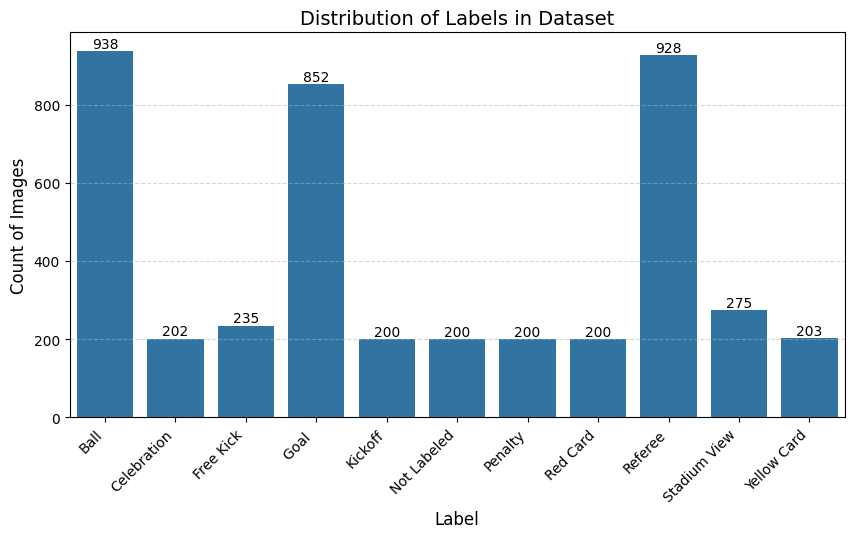

In [11]:
# Plot the labels
plot_label_counts(y)

## Create train and test datasets

In [12]:
# Prepare to split into train and test datasets for modeling
from sklearn.model_selection import train_test_split # import necesary library
test_size = 0.20 # global test size variable

In [13]:
# Import additional torch modules
from torch.utils.data import TensorDataset, DataLoader, random_split

In [14]:
# Train-test split
index_train, index_test, X_train, X_test, y_train, y_test = train_test_split(index, X, y, test_size=test_size, random_state=random_state)

In [15]:
print("X_train shape:", X_train.shape)  # check shape of the train X array which should be (num_samples, num channels, img_dim, img_dim)
print("X_test shape:", X_test.shape)  # check shape of the test X array which should be (num_samples, num channels, img_dim, img_dim)
print("y_train length:", len(y_train)) # check train label length which should be num_samples
print("y_test length:", len(y_test)) # check test label length which should be num_samples

X_train shape: torch.Size([1717, 3, 224, 224])
X_test shape: torch.Size([430, 3, 224, 224])
y_train length: 1717
y_test length: 430


In [16]:
# Use TensorDataset instead for loading via DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

## Count and visualize the class distribution between train and test sets

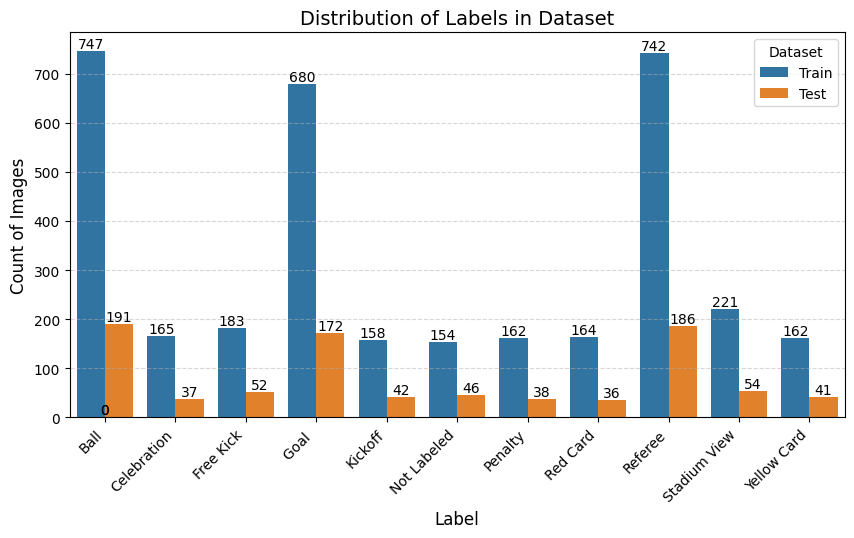

In [17]:
# Plot comparison of label distribution between the train and test sets
plot_label_counts(y_train, y_test)

## Visualize some images to confirm successful prep

In [18]:
# Define function to show an image where x is an image
def show_img(x, title="", bot="", fontsize=10):
    if isinstance(x, torch.Tensor):  # check whether the image is in tensor formate
        x = x.detach().cpu().numpy()  # if it is convert to NumPy and ensure it is moved to CPU
    if x.ndim == 3 and x.shape[0] in [1, 3]:  
        x = x.transpose(1, 2, 0)  # convert from (C, H, W) to (H, W, C) to work with imshow
    plt.imshow(x)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.xlabel(bot, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.plot()

In [19]:
# Define function to revert the multi-hot encoded label index to the labels that are present for display
def present_labels(y):
    present_labels = []
    index_to_label = {v: k for k, v in label_to_idx.items()}
    present_labels = [index_to_label[i] for i, value in enumerate(y) if value == 1]
    return present_labels

In [20]:
# Define function to show some number of images where X is an array of images, y is an array of labels, and n_images is the number of images to be displayed
import math
def display_images(X, y, index, n_images, data):
    plt.figure(figsize=(10 if n_images>=5 else 2*n_images, 2*math.ceil(n_images/5)))
    j=0
    for i in random.sample(range(len(X)), n_images):
        # Plot images with labels
        plt.subplot(math.ceil(n_images/5), 5 if n_images>=5 else n_images, j+1)
        show_img(
            X[i],
            title=", ".join(label.strip() for label in present_labels(y[i])),
            bot=f"Image {list(data.keys())[index[i]]}" # Note, the image # is from the image dictionary and comes from the filename in the original dataset
            )
        plt.plot()
        j += 1
    plt.tight_layout()

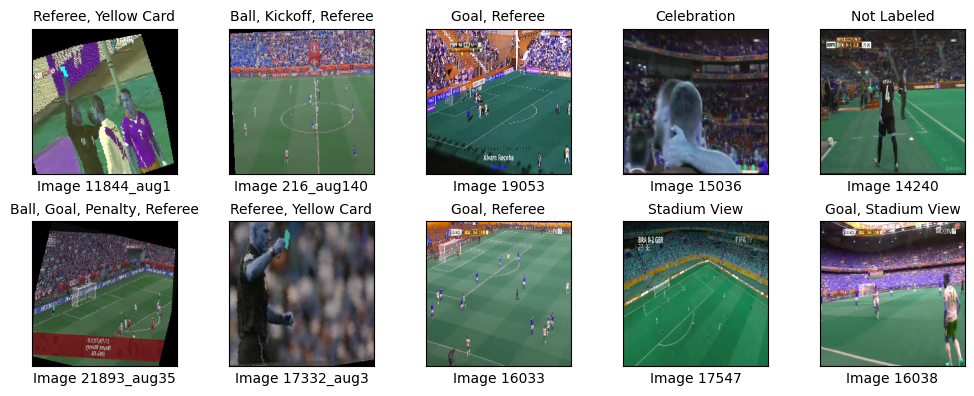

In [21]:
# Preview Train data
# Set the number images to preview
n_images_train = 10
# Show the images
display_images(X_train, y_train, index_train, n_images_train, data)

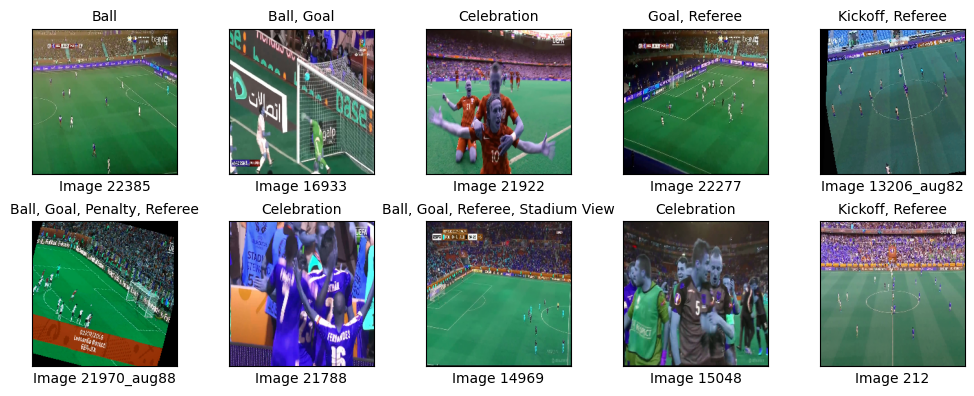

In [22]:
# Preview Test data
# Set the number images to preview
n_images_test = 10
# Show the images
display_images(X_test, y_test, index_test, n_images_test, data)

# Model

## Setup

In [23]:
# Import additional Torch libraries
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

In [24]:
# Create global batch size variable
batch_size = 32

In [25]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [26]:
# Check DataLoader output
for imgs, labels in train_loader:
    print(imgs.shape, labels.shape)  # Expected: torch.Size([batch_size, channels (3), height (224), width (224)]) torch.Size([batch_size, num_labels (11)])
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 11])


In [27]:
# Check which device is available and being used. Use GPU if available.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Define and Build Model

For the baseline model, a CNN will be created using PyTorch to mimic the structure and architecture of the LeNet-5 model as shown in Figure 27 of the Lecture 6 slides. Adjustments will be made to account for the different input size. LeNet-5 was built for grayscale 28x28 images, but this model is evaluating RGB 224x224 images.<br><br>
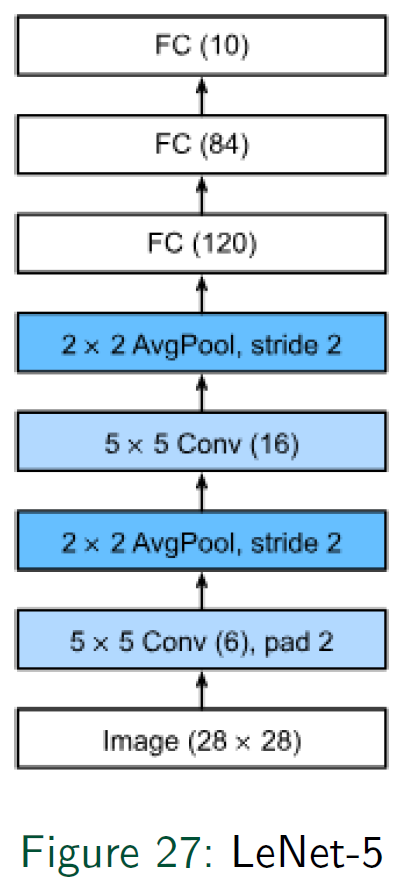
<br><br>
In the final stretch of this project, modifications to the architecture will be experimented with. This may include adjusting hyperparameters, adding layers, or modifying layers (particularly the convolutions) by adding channels and adjusting parameters.

In [28]:
# Define baseline CNN model based on LeNet architecture as shown in Lecture 6 page 38 of 39
class baselineCNN(nn.Module): 
    def __init__(self, num_labels):
        super(baselineCNN, self).__init__()
        
        # Conv layers (5x5 convolution with 6 output channels and padding of 2)
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=2)     

        # Conv layer 2 (5x5 convolution with 16 output channels and no padding)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        
        # Pooling layers (2x2 average pooling with stride 2)
        self.pool = nn.AvgPool2d(2, 2)
        
        # Fully connected layers (120 neurons followed by 84 neurons followed by 11 neurons (one for each label))
        self.fc1 = nn.Linear(16 * 54 * 54, 120)  # inputs the flattened layer,  outputs 120 neuron layer
        self.fc2 = nn.Linear(120, 84)  # outputs 84 neuron layer
        self.fc3 = nn.Linear(84, num_labels)  # outputs num_labels which will be the number of labels in your multi-hot encoding
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))  # Apply convolution + ReLU + Pooling
        x = self.pool(nn.functional.relu(self.conv2(x)))  # Apply convolution 2 + ReLU + Pooling
        x = x.view(-1, 16 * 54 * 54)  # Flatten the output (after pooling), flatten size based on the results of the previous convolutions and pooling: explanation in markdown cell below.
        x = nn.functional.relu(self.fc1(x))  # Fully connected layer
        x = nn.functional.relu(self.fc2(x))  # Fully connected layer 2
        x = self.fc3(x)  # Apply fully connected layer 3 (output layer, raw logits for multi-label classification)
        return x

Flattened Layer Size:
- 16 channels from the second convolution
- For a convolution layer, Output Size is equal to the Input size minus the kernel size plus twice the padding size divided by the stride size plus 1.<br>
    For a 2x2 pooling layer, Output size is equal to Input Size divided by 2.<br>
The given output of 54x54 based on a 224x224 input and the following operations:<br>
    - 5x5 Convolution with padding maintains original input size = 224x224
    - 2x2 Pooling halves the size = 112x112
    - 5x5 convolution without padding = 108x108
    - 2x2 Pooling halves the size = 54x54

In [29]:
# Review the model's structure
summary(baselineCNN(len(label_to_idx.keys())), input_size=(3,224,224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 224, 224]             456
         AvgPool2d-2          [-1, 6, 112, 112]               0
            Conv2d-3         [-1, 16, 108, 108]           2,416
         AvgPool2d-4           [-1, 16, 54, 54]               0
            Linear-5                  [-1, 120]       5,598,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 11]             935
Total params: 5,612,811
Trainable params: 5,612,811
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.65
Params size (MB): 21.41
Estimated Total Size (MB): 26.64
----------------------------------------------------------------


In [30]:
# Define the model and load it to GPU if available
model = baselineCNN(len(label_to_idx.keys()))
model.to(device)

baselineCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
)

In [31]:
# Set hyperparameters 
learning_rate = 0.001
epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Train Model

In [32]:
%%time
# Train model
train_losses = [] # initialize variable to store each epoch loss
for epoch in range(epochs):
    epoch_loss = 0.0 # initialize variable for epoch loss
    model.train() # set model to train
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.float().to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # Print progress messages
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_loss /= len(train_loader) # calculate average loss for the epoch
    print(f'Epoch [{epoch + 1}/{epochs}] Epoch Loss: {epoch_loss:.4f}')
    
    train_losses.append(epoch_loss) # store the losses of each epoch

Epoch [1/10], Step [10/54], Loss: 0.4406
Epoch [1/10], Step [20/54], Loss: 0.4176
Epoch [1/10], Step [30/54], Loss: 0.4264
Epoch [1/10], Step [40/54], Loss: 0.4126
Epoch [1/10], Step [50/54], Loss: 0.3608
Epoch [1/10] Epoch Loss: 0.4253
Epoch [2/10], Step [10/54], Loss: 0.3634
Epoch [2/10], Step [20/54], Loss: 0.3735
Epoch [2/10], Step [30/54], Loss: 0.2943
Epoch [2/10], Step [40/54], Loss: 0.3677
Epoch [2/10], Step [50/54], Loss: 0.3281
Epoch [2/10] Epoch Loss: 0.3468
Epoch [3/10], Step [10/54], Loss: 0.3224
Epoch [3/10], Step [20/54], Loss: 0.2718
Epoch [3/10], Step [30/54], Loss: 0.3196
Epoch [3/10], Step [40/54], Loss: 0.3702
Epoch [3/10], Step [50/54], Loss: 0.2614
Epoch [3/10] Epoch Loss: 0.3110
Epoch [4/10], Step [10/54], Loss: 0.2621
Epoch [4/10], Step [20/54], Loss: 0.3025
Epoch [4/10], Step [30/54], Loss: 0.2900
Epoch [4/10], Step [40/54], Loss: 0.2609
Epoch [4/10], Step [50/54], Loss: 0.2778
Epoch [4/10] Epoch Loss: 0.2907
Epoch [5/10], Step [10/54], Loss: 0.2479
Epoch [5/10

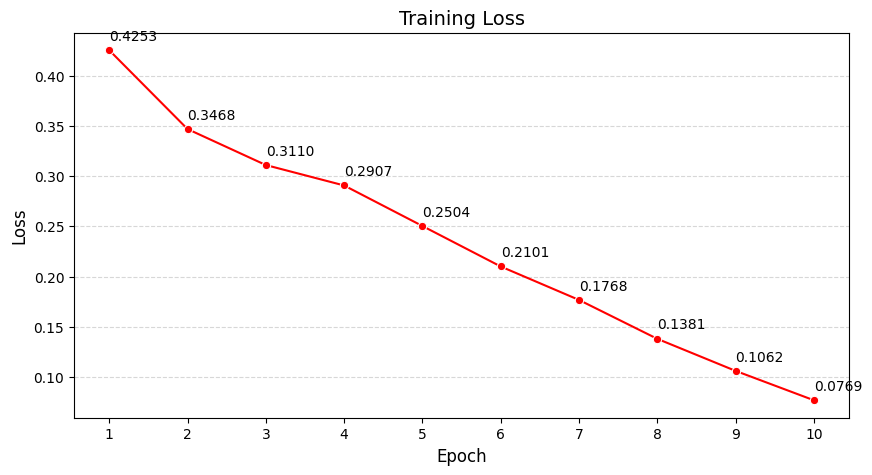

In [33]:
# Plot training loss
plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=range(1, epochs+1), y=train_losses, color="red", marker="o")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(range(1, epochs+1))
# Annotate each point on the line with its value
for epoch, loss in zip(range(1, epochs+1), train_losses):
    ax.annotate(
        f'{loss:.4f}',  # Annotate the point with the loss value (formatted to 4 decimal places)
        (epoch, loss),  # Position the annotation at the (epoch, loss) coordinates
        textcoords="offset points",  # Use an offset to prevent overlap with the line
        xytext=(0, 5),  # Slightly offset the text from the point (5 pixels above)
        ha="left",  # Center the text horizontally
        va="bottom"   # Align the text to the bottom of the point
    )
plt.show()

## Test Model

In [34]:
# Test model
# Create variables to calculate and update accuracy within each sample
correct, total = 0, 0
# Create a variable to store predictions
test_images = []
test_labels = []
predictions = []

# Define a threshold for classification
threshold = 0.5 # if logit is >=0.5 assign the label

# Run the model on the test samples
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader, 0):
        images, labels = images.float().to(device), labels.to(device)
        outputs = model(images)
        # Apply sigmoid activation to get probabilities for each label
        probs = torch.sigmoid(outputs)
        predicted = (probs > threshold).float() # predict label if its probability meets threshold

        total += labels.numel()
        correct += (predicted == labels).sum().item()

        test_images.append(images)
        test_labels.append(labels)
        predictions.append(predicted)

print(f"Accuracy on the test set: {correct/total:.2%}")

Accuracy on the test set: 88.73%


In [35]:
# Define function to visualize image label predictions
def display_predictions(X, predicted, actual, index, n_images, fontsize=10):
    plt.figure(figsize=(10 if n_images>=5 else 2*n_images, 2*math.ceil(n_images/5)))
    j=0
    # Copy image tensors to CPU to work with numpy
    X=X.cpu()
    predicted=predicted.cpu().tolist()
    actual=actual.cpu().tolist()
    # Prep images
    random.seed(random_state)
    for i in random.sample(range(len(X)), n_images):
        plt.subplot(math.ceil(n_images/5), 5 if n_images>=5 else n_images, j+1)
        show_img(
            X[i],
            title=f"Predicted: {', '.join(present_labels(predicted[i]))}",
            bot=f"Actual: {', '.join(present_labels(actual[i]))}\nImage {list(data.keys())[index[i]]}",
            fontsize=fontsize
            )
        plt.plot()
        j += 1
    plt.tight_layout()

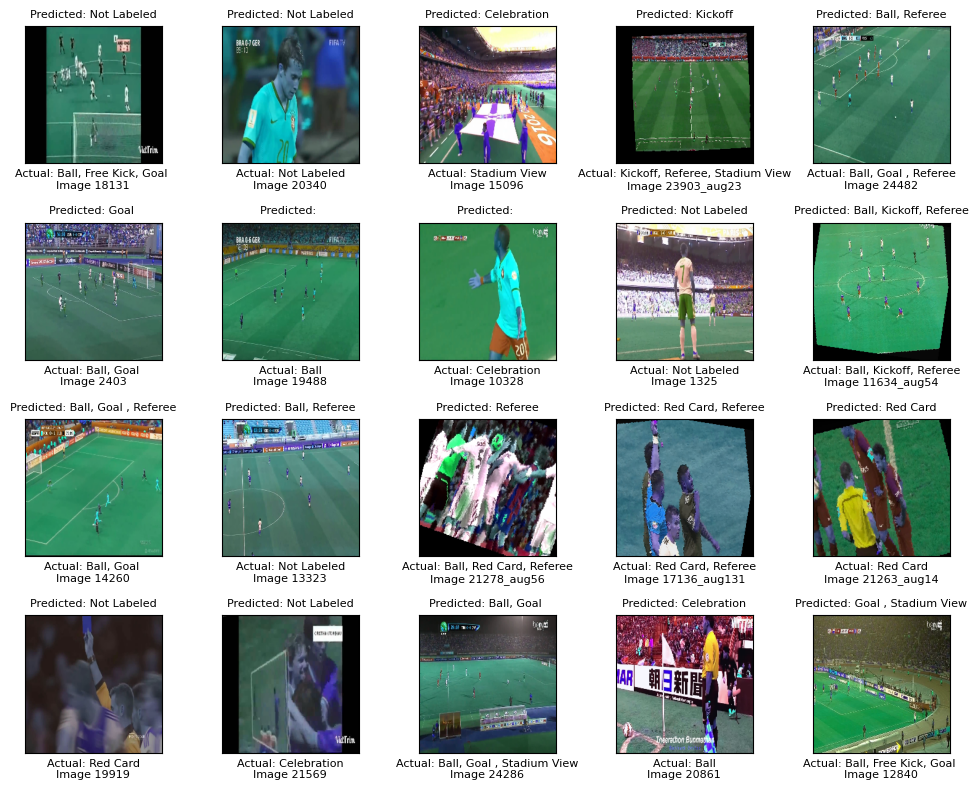

In [36]:
# Visualize Test predictions
# Set the number images to preview
n_images_pred = 20
# Show the images
display_predictions(torch.cat(test_images), torch.cat(predictions), torch.cat(test_labels), index_test, n_images_pred, fontsize=8)

In [37]:
# Generate classification metrics for the model performance on the test data
from sklearn.metrics import multilabel_confusion_matrix, classification_report
idx_to_label = {v: k for k, v in label_to_idx.items()} # reverse the labels to index dictionary
confusion_matrices = multilabel_confusion_matrix(torch.cat(test_labels).cpu(), torch.cat(predictions).cpu()) # generate confusion matrices for each label
report = classification_report(torch.cat(test_labels).cpu(), torch.cat(predictions).cpu(), zero_division=np.nan, labels=(list(idx_to_label.keys())), target_names=(list(idx_to_label.values())), output_dict=True) # generate classification report and store in dictionary
report_display = classification_report(torch.cat(test_labels).cpu(), torch.cat(predictions).cpu(), zero_division=np.nan, labels=(list(idx_to_label.keys())), target_names=(list(idx_to_label.values())), output_dict=False) # generate classification report for display

In [38]:
# Display classification report
print(report_display)

              precision    recall  f1-score   support

        Ball       0.66      0.69      0.68       191
 Celebration       0.57      0.43      0.49        37
   Free Kick       0.76      0.56      0.64        52
       Goal        0.84      0.77      0.81       172
     Kickoff       0.89      0.76      0.82        42
 Not Labeled       0.43      0.28      0.34        46
     Penalty       1.00      0.66      0.79        38
    Red Card       0.88      0.39      0.54        36
     Referee       0.70      0.80      0.75       186
Stadium View       0.70      0.39      0.50        54
 Yellow Card       0.56      0.73      0.63        41

   micro avg       0.72      0.66      0.69       895
   macro avg       0.73      0.59      0.64       895
weighted avg       0.73      0.66      0.68       895
 samples avg       0.68      0.61      0.60       895



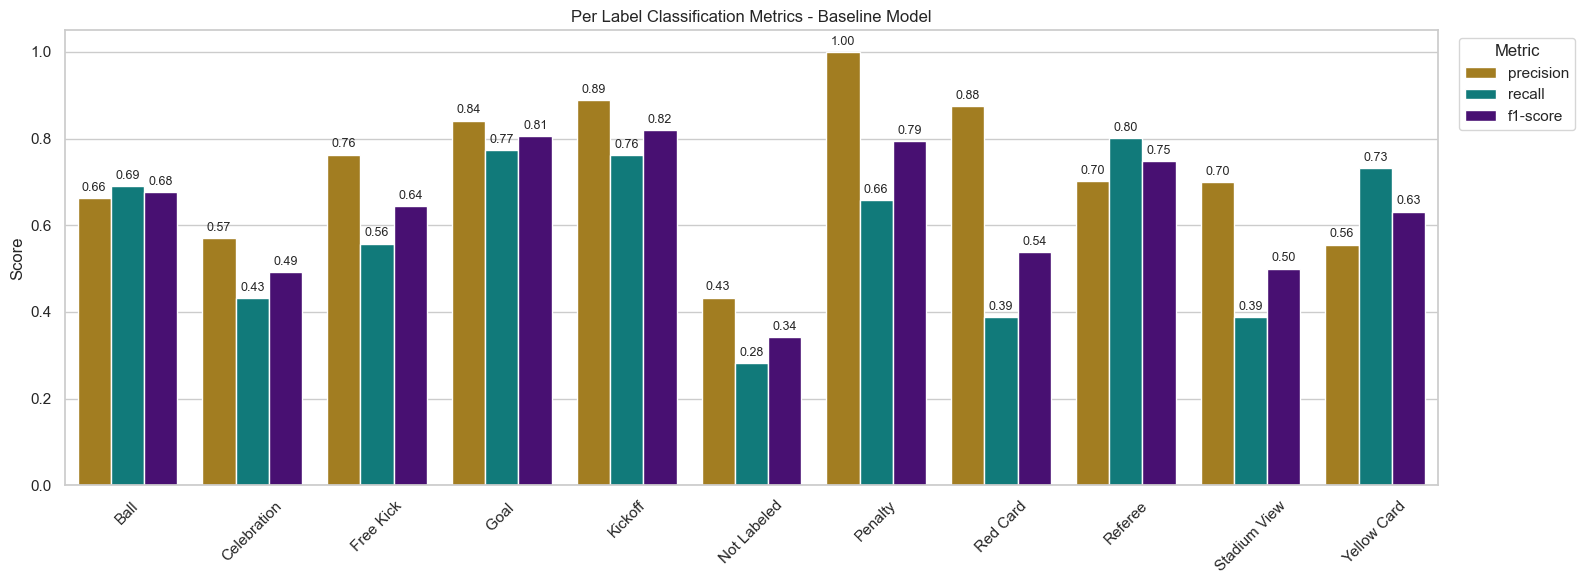

In [39]:
# Plot metrics
report_df = pd.DataFrame(report).transpose() # convert classification report to dataframe to use for visualization and display output
report_df = report_df.loc[unique_labels, ["precision", "recall", "f1-score"]] # isolate just the metrics and labels
report_df = report_df.reset_index().rename(columns={"index": "label"}) # reset index to prepare df for melt
report_df_melt = report_df.melt(id_vars="label", var_name="metric", value_name='score') # melt df to use for plotting

plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
ax = sns.barplot(data=report_df_melt, x="label", y="score", hue="metric", palette=["darkgoldenrod", "darkcyan", "indigo"])
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)
plt.title("Per Label Classification Metrics - Baseline Model")
plt.ylabel("Score")
plt.xlabel("")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(title="Metric", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.tight_layout()
plt.show()

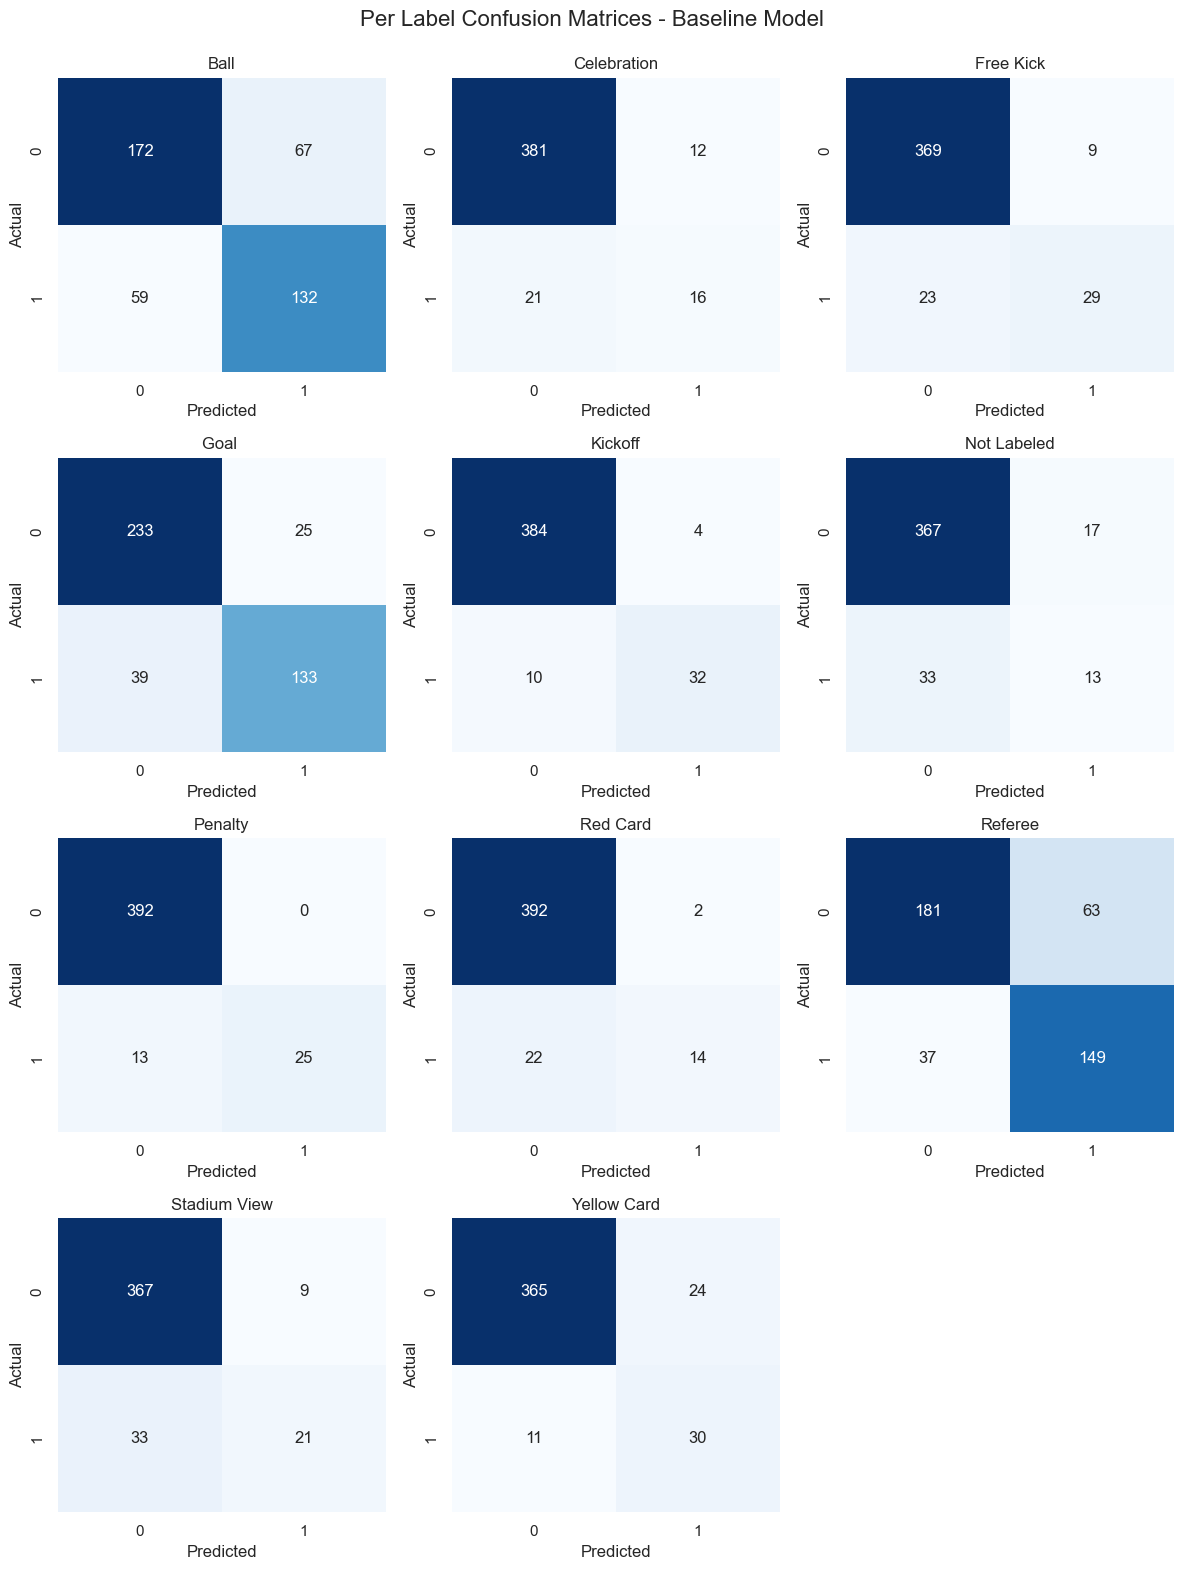

In [40]:
# Plot all confusion matrices as subplots
plot_rows = 4
plot_cols = math.ceil(len(confusion_matrices)/plot_rows)

fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(4*plot_cols, 4*plot_rows))
axes=axes.flatten()
for i, (matrix, label) in enumerate(zip(confusion_matrices, labels)):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(f"{idx_to_label[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Per Label Confusion Matrices - Baseline Model\n", fontsize=16)

plt.tight_layout()
plt.show()